### The purpose of this notebook is to investigate snowfall in Washington, DC. The data set includes daily weather metrics and descriptions from August 2015 - August 2024. 

### Analyses will investigate whether weather metrics can be used to classify whether snow falls on a given day (as a binary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import metrics
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings('ignore')
%load_ext rpy2.ipython

In [2]:
data = pd.read_csv('dc_weather.csv')
data

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2015-08-01,33.1,22.8,28.2,34.0,22.8,28.6,17.4,53.3,...,22.9,8,NaN,2015-08-01T06:08:52,2015-08-01T20:19:30,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,..."
1,"Washington,DC,USA",2015-08-02,32.0,22.8,27.3,31.1,22.8,27.2,15.4,49.1,...,22.4,8,NaN,2015-08-02T06:09:44,2015-08-02T20:18:29,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,..."
2,"Washington,DC,USA",2015-08-03,33.2,21.8,27.9,34.9,21.8,28.7,18.6,58.7,...,24.1,9,NaN,2015-08-03T06:10:38,2015-08-03T20:17:26,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
3,"Washington,DC,USA",2015-08-04,35.3,24.9,29.3,36.6,24.9,30.4,19.0,55.2,...,21.9,9,NaN,2015-08-04T06:11:31,2015-08-04T20:16:22,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,72403793728,KADW,KDAA,7459401..."
4,"Washington,DC,USA",2015-08-05,33.6,24.0,28.6,33.0,24.0,28.6,17.6,55.3,...,23.7,9,NaN,2015-08-05T06:12:24,2015-08-05T20:15:16,0.68,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KDCA,72405013743,72403793728,KGAI,KADW,KDAA,72..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,"Washington,DC,USA",2024-08-27,33.3,22.5,27.7,33.7,22.5,27.9,18.9,62.4,...,18.1,8,10.0,2024-08-27T06:33:04,2024-08-27T19:45:18,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."
3315,"Washington,DC,USA",2024-08-28,37.8,24.2,30.2,39.7,24.2,31.9,20.4,58.7,...,16.9,7,10.0,2024-08-28T06:33:58,2024-08-28T19:43:49,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
3316,"Washington,DC,USA",2024-08-29,32.8,23.3,28.1,38.1,23.3,30.3,21.9,69.7,...,11.5,8,60.0,2024-08-29T06:34:52,2024-08-29T19:42:19,0.85,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."
3317,"Washington,DC,USA",2024-08-30,23.8,22.2,22.9,23.8,22.2,22.9,20.8,87.6,...,3.4,2,10.0,2024-08-30T06:35:45,2024-08-30T19:40:48,0.88,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,D6279,72403793728,KGAI,KADW,K..."


### Description of variables

![title](variables.png)

#### Variable of interest here is "snow". 

#### Adding columns for year, month, and day. 

#### Adding a column, 'AnySnow', which will be a binary variable of whether there any amount of snow falls (1) or no snow falls (0).

#### Also adding a column to indicate the "winter" a data point is apart of (so that December 2023 and January 2024, for example, can be analyzed as part of the same winter). 
    This column will be titled "newYear", indicating the new year that occurred during a given winter. 
    
    So that all data points have a value for newYear, the cutoff will be July. For example, July 2023-June 2024 will have newYear value of 2024.

In [3]:
# creating year, month, day columns 

datestring = data.datetime.unique()

year=[]
month=[]
day=[]

for date in datestring:
    
    y = date[:4]
    m = date[5:7]
    d = date[8:]
    
    year.append([y])
    month.append([m])
    day.append([d])
    
year = pd.DataFrame(year,columns=['year'])
month = pd.DataFrame(month,columns=['month'])
day = pd.DataFrame(day,columns=['day'])

data=pd.concat([data,year,month,day],axis=1)

In [4]:
# add a column where snowfall is > 0 

AnySnow = []

for i in range (len(data)):
    
    if data.snow[i] > 0:
        snowFall = 1
    else: snowFall = 0
    
    AnySnow.append([snowFall])
    
AnySnow = pd.DataFrame(AnySnow, columns=['AnySnow'])
data=pd.concat([data,AnySnow],axis=1)   

In [5]:
data.month = (data.month).astype(float)
data.year = (data.year).astype(float)

winter=[]
for i,y in enumerate(data.year):
        
    if (data.month[i]<7):
        wint = y
        winter.append(wint)
        
    else: 
        wint = y+1
        winter.append(wint)
    
    
            
    newYear = pd.DataFrame(winter,columns=['newYear'])

In [6]:
data=pd.concat([data,newYear],axis=1)
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,moonphase,conditions,description,icon,stations,year,month,day,AnySnow,newYear
0,"Washington,DC,USA",2015-08-01,33.1,22.8,28.2,34.0,22.8,28.6,17.4,53.3,...,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,...",2015.0,8.0,01,0,2016.0
1,"Washington,DC,USA",2015-08-02,32.0,22.8,27.3,31.1,22.8,27.2,15.4,49.1,...,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KIAD,KDCA,72405013743,72403793728,72403093738,...",2015.0,8.0,02,0,2016.0
2,"Washington,DC,USA",2015-08-03,33.2,21.8,27.9,34.9,21.8,28.7,18.6,58.7,...,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,KADW,KDAA,7459401...",2015.0,8.0,03,0,2016.0
3,"Washington,DC,USA",2015-08-04,35.3,24.9,29.3,36.6,24.9,30.4,19.0,55.2,...,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"KDCA,72405013743,72403793728,KADW,KDAA,7459401...",2015.0,8.0,04,0,2016.0
4,"Washington,DC,USA",2015-08-05,33.6,24.0,28.6,33.0,24.0,28.6,17.6,55.3,...,0.68,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"KDCA,72405013743,72403793728,KGAI,KADW,KDAA,72...",2015.0,8.0,05,0,2016.0


### Visualize data:

Text(0.5, 0, '')

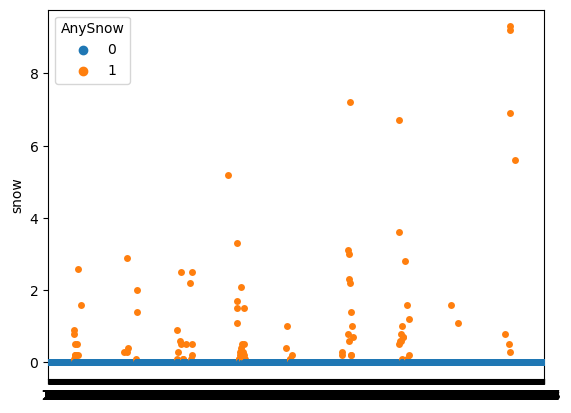

In [7]:
sns.stripplot(x=data.index, y=data.snow, hue=data['AnySnow'])
plt.xlabel('')

### Visualizing snow winter by winter:

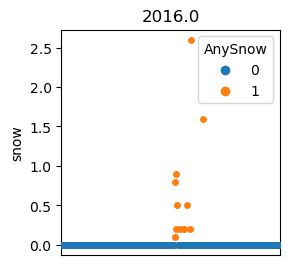

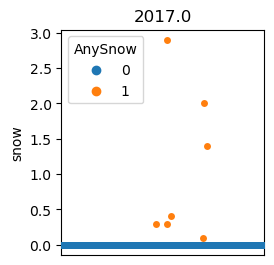

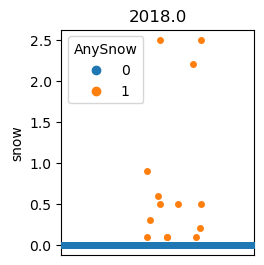

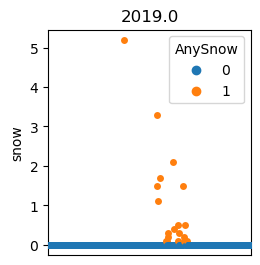

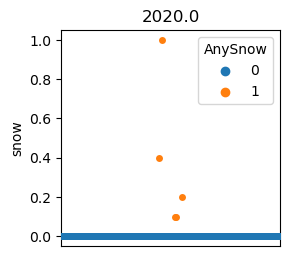

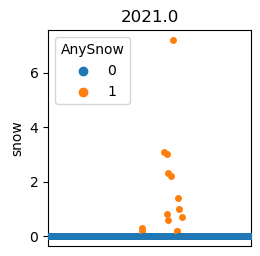

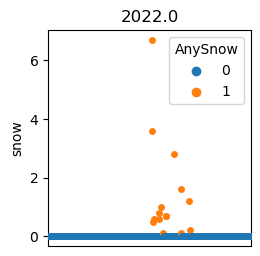

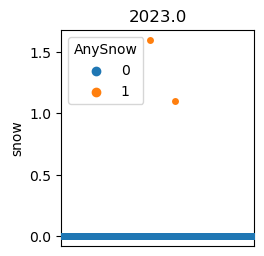

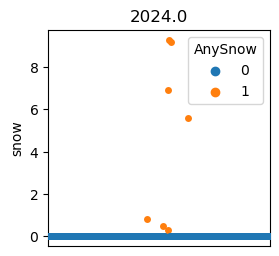

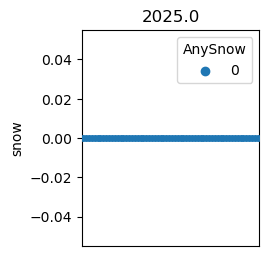

In [8]:
newYear = data.newYear.unique()
for i,y in enumerate(newYear):
    plt.figure(figsize=(10,10))
    plt.subplot(4,4,i+1)
    sns.stripplot(x=data.index[data.newYear==y], y=data.snow[data.newYear==y], hue=data['AnySnow'][data.newYear==y])
    plt.xlabel('')
    plt.xticks([])
    plt.title(y)
    plt.tight_layout()

#### This is a large data set that likely has many correlated variables (e.g. temp and feelslike). We will use PCA to reduce the number of features to visualize if days with and without snow can be separated more clearly than the plots above.

##### Only including numeric variables for PCA:

In [9]:
data_pca = data[['tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover','snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex','moonphase','AnySnow']]

In [10]:
data_pca.corr()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,AnySnow
tempmax,1.000000,0.940168,0.982526,0.992413,0.942842,0.980997,0.904933,0.184334,0.012904,0.008523,...,-0.149606,-0.079774,-0.306538,-0.078761,0.196612,0.448724,0.448228,0.478738,-0.005443,-0.287912
tempmin,0.940168,1.000000,0.983464,0.939570,0.994499,0.978927,0.954152,0.317063,0.094974,0.123495,...,-0.159229,-0.130617,-0.342406,0.093095,0.089409,0.320034,0.319450,0.331881,-0.009826,-0.254449
temp,0.982526,0.983464,1.000000,0.977479,0.982399,0.996619,0.940691,0.241307,0.048295,0.056934,...,-0.156159,-0.101520,-0.328540,-0.000451,0.151052,0.396731,0.396190,0.415889,-0.008406,-0.279517
feelslikemax,0.992413,0.939570,0.977479,1.000000,0.941725,0.981984,0.913461,0.219051,0.029187,0.031444,...,-0.158179,-0.093074,-0.305999,-0.056070,0.183113,0.422566,0.422050,0.453630,-0.004288,-0.291751
feelslikemin,0.942842,0.994499,0.982399,0.941725,1.000000,0.982965,0.957151,0.330550,0.087016,0.110772,...,-0.198666,-0.150159,-0.329846,0.091473,0.088676,0.318776,0.318309,0.330034,-0.010656,-0.271745
feelslike,0.980997,0.978927,0.996619,0.981984,0.982965,1.000000,0.944948,0.262689,0.048329,0.057101,...,-0.182767,-0.119341,-0.321453,0.007383,0.144217,0.384611,0.384112,0.403430,-0.008650,-0.292085
dew,0.904933,0.954152,0.940691,0.913461,0.957151,0.944948,1.000000,0.552676,0.176728,0.221374,...,-0.224338,-0.217980,-0.354848,0.198481,-0.041886,0.195939,0.195339,0.195684,-0.008310,-0.221506
humidity,0.184334,0.317063,0.241307,0.219051,0.330550,0.262689,0.552676,1.000000,0.411088,0.512438,...,-0.253389,-0.374812,-0.227042,0.569046,-0.550320,-0.406297,-0.406717,-0.461637,-0.007520,0.059005
precip,0.012904,0.094974,0.048295,0.029187,0.087016,0.048329,0.176728,0.411088,1.000000,0.439765,...,0.139820,-0.160872,-0.210437,0.324759,-0.488251,-0.270923,-0.271645,-0.299538,-0.016729,0.076425
precipprob,0.008523,0.123495,0.056934,0.031444,0.110772,0.057101,0.221374,0.512438,0.439765,1.000000,...,0.172108,-0.087330,-0.352995,0.475783,-0.404762,-0.309841,-0.309894,-0.332926,-0.017681,0.138302


#### We can see above that some variables are very strongly correlated.

<Axes: xlabel='pc1', ylabel='pc2'>

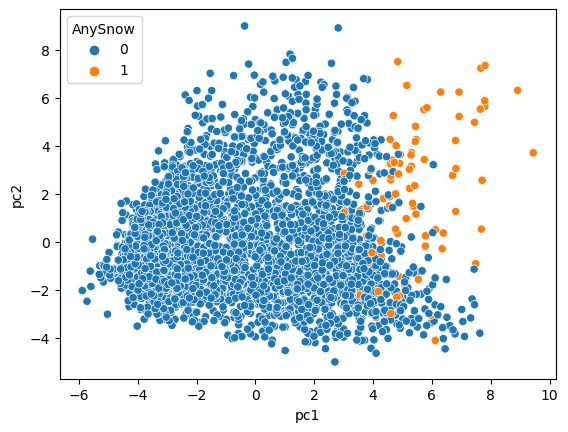

In [11]:
x = data_pca.loc[:,data_pca.columns!='AnySnow'].values
x = StandardScaler().fit_transform(x)
y = data_pca['AnySnow'].values

pca_binary = PCA(n_components=23) 

principalComponents = pca_binary.fit_transform(x)

pcDF = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3', 'pc4','pc5', 'pc6','pc7', 'pc8','pc9', 'pc10',
                         'pc11', 'pc12','pc13', 'pc14','pc15', 'pc16','pc17', 'pc18','pc19', 'pc20',
                         'pc21', 'pc22','pc23'])

PCA_data = pd.concat([pcDF, data[['AnySnow']]], axis = 1)

sns.scatterplot(data=PCA_data, x='pc1', y='pc2', hue='AnySnow')

In [12]:
pca_binary.explained_variance_ratio_

array([3.36775520e-01, 2.20659365e-01, 1.07906818e-01, 6.59089727e-02,
       4.94550836e-02, 4.30156507e-02, 3.05072342e-02, 2.92808026e-02,
       2.25885170e-02, 2.07410532e-02, 1.89645084e-02, 1.78185983e-02,
       1.15290070e-02, 8.63378830e-03, 6.73479853e-03, 5.20248620e-03,
       3.33691205e-03, 3.66035573e-04, 2.53639214e-04, 2.45128172e-04,
       5.15201450e-05, 1.82955196e-05, 6.26563884e-06])

#### The first two principal components seem to explain the majority of the variance in the data (~55%). 

#### When we add a hue based on if there was snow or not, we can see that the data does seem to be somewhat separable along the first PC axis.

<StemContainer object of 3 artists>

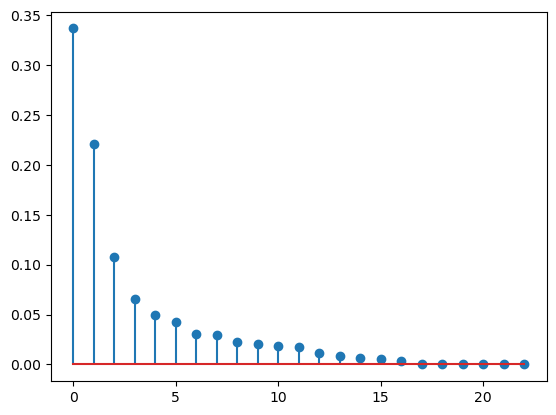

In [13]:
plt.stem(pca_binary.explained_variance_ratio_)

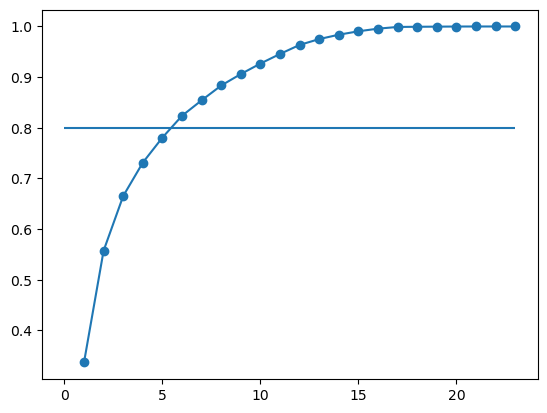

In [14]:
plt.plot(range(1,24),pca_binary.explained_variance_ratio_.cumsum(),marker='o')
plt.hlines(y=0.8,xmin=0,xmax=23)

#### n=6 components captures 80% of the variance in the data.

### We will use PCA with 6 components, and will see if the PC scores can be used to cluster the data in a meaningful way using K-means clusters.

In [15]:
pca = PCA(n_components=6)
pca.fit(x)

PCA(n_components=6)

In [16]:
pca_scores = pca.transform(x)

In [17]:
np.shape(pca_scores)

(3319, 6)

In [18]:
wcss = [] #within cluster sum of squares; want to be minimized

for i in range(1,101):

    kmeans_pca = KMeans(n_clusters=i, random_state=10, n_init='auto')
    kmeans_pca.fit(pca_scores)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'Within Cluster SS')

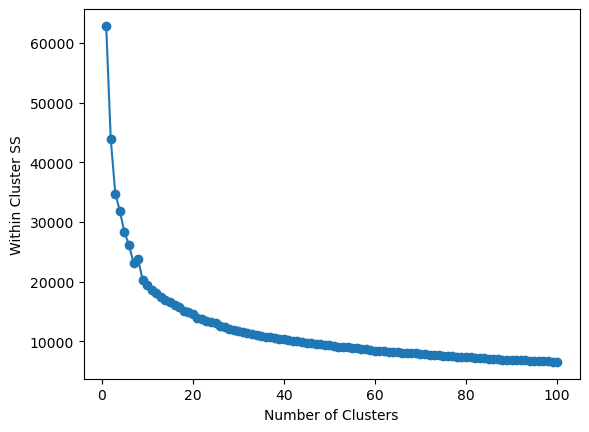

In [19]:
plt.plot(range(1,101), wcss, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster SS')

Text(0, 0.5, 'Within Cluster SS')

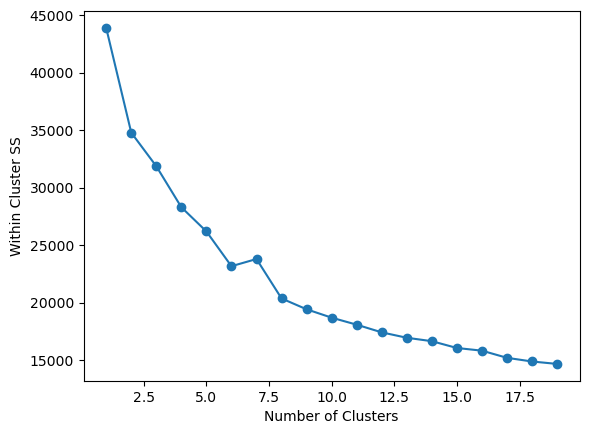

In [20]:
plt.plot(range(1,20), wcss[1:20], marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster SS')

### The 'elbow', or where there seems to be the largest drop off for within-cluster SS, seems to occur at 2 clusters.

In [21]:
kmeans_pca = KMeans(n_clusters=2, random_state=10,n_init='auto')
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=2, n_init='auto', random_state=10)

In [22]:
np.shape(kmeans_pca.labels_)

(3319,)

In [23]:
np.shape(pca_scores)

(3319, 6)

In [24]:
pcDF = pd.DataFrame(pca_scores, columns=['pc1','pc2','pc3','pc4','pc5','pc6'])
kmeansDF = pd.DataFrame(kmeans_pca.labels_,columns=['cluster'])
kmeans_pca_data = pd.concat([data[['AnySnow']],pcDF,kmeansDF],axis=1)

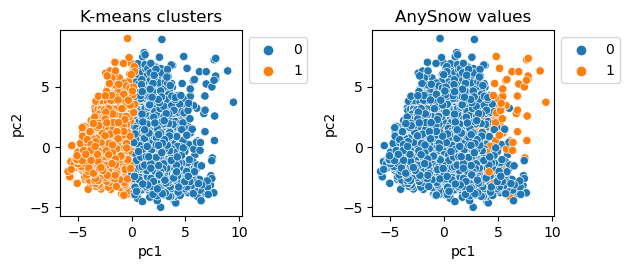

In [25]:
plt.subplot(2,2,1)
sns.scatterplot(x=kmeans_pca_data.pc1, y=kmeans_pca_data.pc2, hue=kmeans_pca_data.cluster)
plt.title('K-means clusters')
plt.legend(bbox_to_anchor=[1, 1])

plt.subplot(2,2,2)
sns.scatterplot(x=kmeans_pca_data.pc1, y=kmeans_pca_data.pc2, hue=kmeans_pca_data.AnySnow)
plt.title('AnySnow values')
plt.legend(bbox_to_anchor=[1, 1])

plt.tight_layout()

### It seems as though we can separate the data into two clusters along PC1 axis. But, this may not be the best way to separate days with and without snow when we compare the two plots above.

### Let's try another method that will tells us more about what variables/features are most important in separating AnySnow.

# Classification tree
    Seeing what variables are most important in splitting up the binary AnySnow variable while accounting for the fact that it may not be a perfect linear split.
    
    This will also help us have a better understanding of how to visualize the data set.

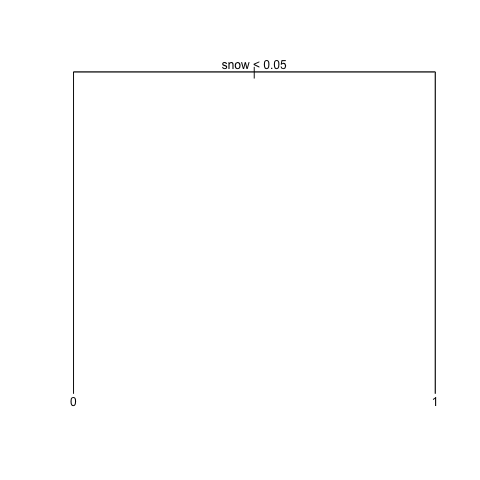

In [26]:
%%R -i data_pca
library(tree)

tr <- tree(as.factor(AnySnow) ~ . , data = data_pca)
plot(tr)
text(tr)

### Exclude snow.

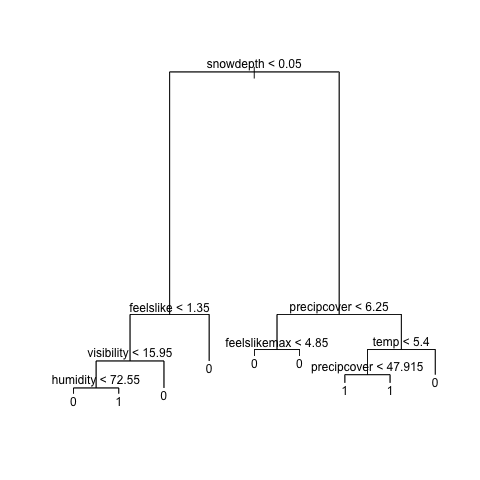

In [27]:
%%R -i data_pca
library(tree)

tr <- tree(as.factor(AnySnow) ~ . -snow, data = data_pca)
plot(tr)
text(tr)

In [28]:
%%R
summary(tr)


Classification tree:
tree(formula = as.factor(AnySnow) ~ . - snow, data = data_pca)
Variables actually used in tree construction:
[1] "snowdepth"    "feelslike"    "visibility"   "humidity"     "precipcover" 
[6] "feelslikemax" "temp"        
Number of terminal nodes:  9 
Residual mean deviance:  0.0672 = 222.4 / 3310 
Misclassification error rate: 0.01416 = 47 / 3319 


### If there is already snow on the ground, this appears to be indiciative of if it will snow on a given day.

#### Plotting data based on some of the variables used the nodes above

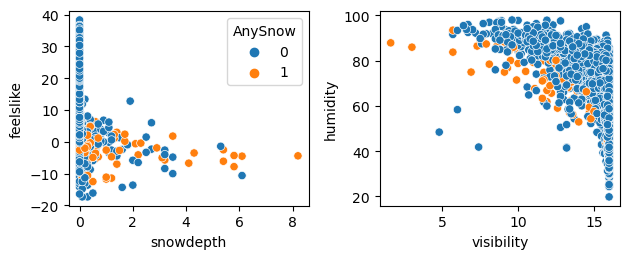

In [29]:
plt.subplot(2,2,1)
sns.scatterplot(data=data_pca, x='snowdepth', y='feelslike', hue='AnySnow')

plt.subplot(2,2,2)
ax=sns.scatterplot(data=data_pca, x='visibility', y='humidity', hue='AnySnow')
ax.get_legend().remove()
plt.tight_layout()

### Let's also exclude snowdepth to see what variables *unrelated* to snow are important in predicting if snow falls.

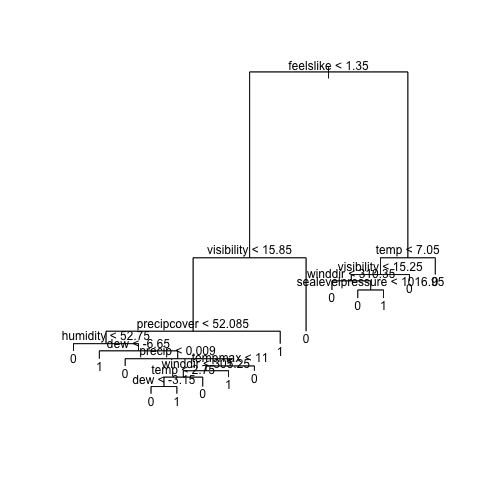

In [30]:
%%R -i data_pca

data_pca_subset <- subset(data_pca, select = -c(snow, snowdepth))

tr <- tree(as.factor(AnySnow) ~ . , data = data_pca_subset)
plot(tr)
text(tr)

In [31]:
%%R
summary(tr)


Classification tree:
tree(formula = as.factor(AnySnow) ~ ., data = data_pca_subset)
Variables actually used in tree construction:
 [1] "feelslike"        "visibility"       "precipcover"      "humidity"        
 [5] "dew"              "precip"           "tempmax"          "winddir"         
 [9] "temp"             "sealevelpressure"
Number of terminal nodes:  15 
Residual mean deviance:  0.05463 = 180.5 / 3304 
Misclassification error rate: 0.007834 = 26 / 3319 


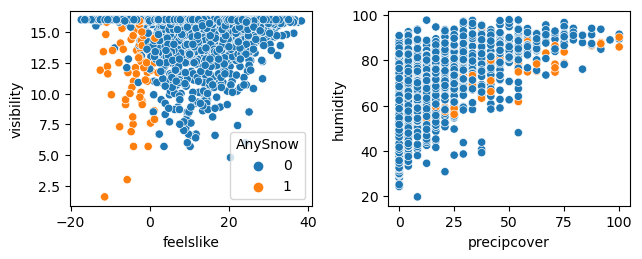

In [32]:
plt.subplot(2,2,1)
sns.scatterplot(data=data_pca, x='feelslike', y='visibility', hue='AnySnow')

plt.subplot(2,2,2)
ax=sns.scatterplot(data=data_pca, x='precipcover', y='humidity', hue='AnySnow')
ax.get_legend().remove()
plt.tight_layout()

### Pruning tree to avoid overfitting:

In [33]:
%%R
set.seed(1234)
cv <- cv.tree(tr)
cv

$size
[1] 15 11 10  8  5  4  3  2  1

$dev
[1] 536.0744 448.4146 449.5814 449.5437 452.4760 442.4701 448.1890 564.2515
[9] 856.3287

$k
[1]      -Inf  12.93036  13.49771  14.02863  14.62559  23.13055  31.25706
[8] 136.91012 346.40578

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"


In [34]:
%%R
cv$size[which.min(cv$dev)]

[1] 4


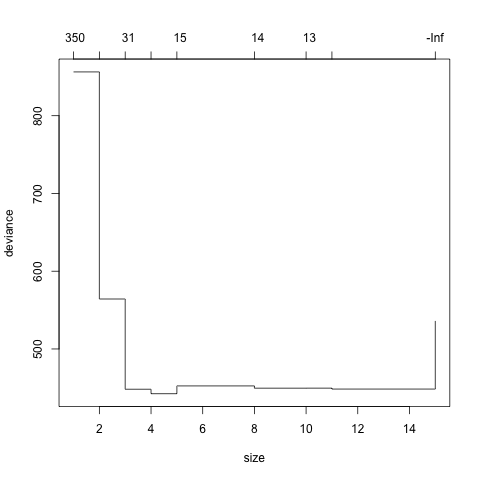

In [35]:
%%R
plot(cv)

In [36]:
%%R
tr_opt <- prune.tree(tr, best = 4)
summary(tr_opt)


Classification tree:
snip.tree(tree = tr, nodes = c(6L, 4L))
Variables actually used in tree construction:
[1] "feelslike"  "visibility" "temp"      
Number of terminal nodes:  4 
Residual mean deviance:  0.1028 = 340.8 / 3315 
Misclassification error rate: 0.02109 = 70 / 3319 


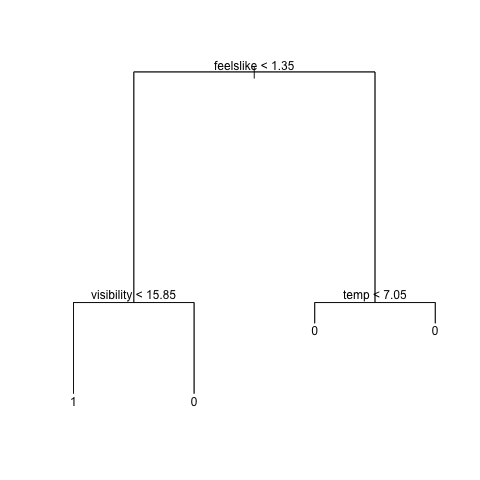

In [37]:
%%R
plot(tr_opt)
text(tr_opt)

### Having 4 nodes seems unecessary - can see that whether temp is greater or less than 7.05, the day is classified as 0, no snow. Let's re-prune with 3 nodes.

In [38]:
%%R
tr_opt <- prune.tree(tr, best = 3)
summary(tr_opt)


Classification tree:
snip.tree(tree = tr, nodes = 4:3)
Variables actually used in tree construction:
[1] "feelslike"  "visibility"
Number of terminal nodes:  3 
Residual mean deviance:  0.1122 = 372.1 / 3316 
Misclassification error rate: 0.02109 = 70 / 3319 


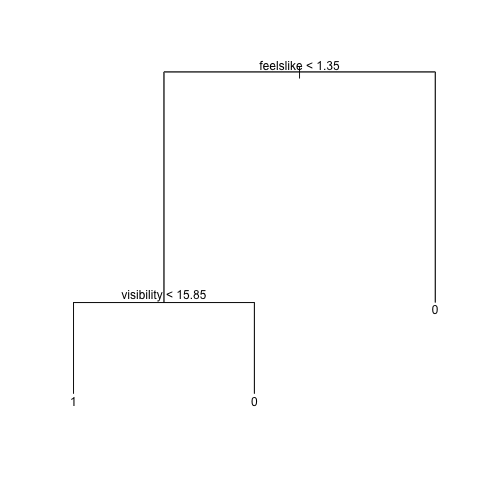

In [39]:
%%R
plot(tr_opt)
text(tr_opt)

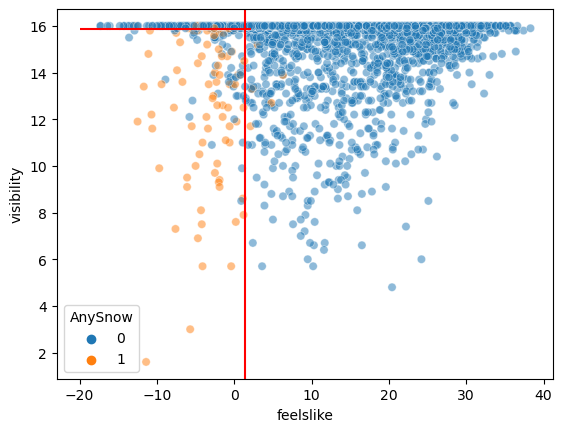

In [40]:
sns.scatterplot(data=data_pca, x='feelslike', y='visibility', hue='AnySnow', alpha=0.5)
plt.axvline(x=1.35,color='red')
plt.hlines(y=15.85,xmin=-20,xmax=2.15,color='red')

#### This seems as though days with and without snow can be classified pretty well based on these splits.

## Random forest
    Building multiple trees and averaging them for a model with better prediction.

In [41]:
%%R -i data_pca
library(randomForest)

set.seed(123)

BAG <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset)
BAG


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = data_pca_subset) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 1.57%
Confusion matrix:
     0  1 class.error
0 3214 11 0.003410853
1   41 53 0.436170213


randomForest 4.7-1.2
Type rfNews() to see new features/changes/bug fixes.
In addition: Warning message:
package ‘randomForest’ was built under R version 4.3.3 


In [42]:
%%R
importance(BAG)

                 MeanDecreaseGini
tempmax                 11.810742
tempmin                  8.170008
temp                    14.745251
feelslikemax            11.338438
feelslikemin             8.868799
feelslike               15.461663
dew                      7.879444
humidity                10.975932
precip                  12.284000
precipprob               4.706720
precipcover             12.237695
windgust                 4.250046
windspeed                4.864074
winddir                  6.361346
sealevelpressure         4.145204
cloudcover               4.872719
visibility              18.352346
solarradiation           7.794376
solarenergy              6.788562
uvindex                  2.834228
moonphase                3.888690


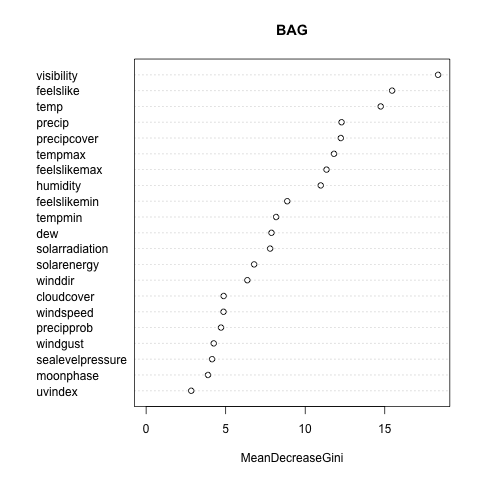

In [43]:
%%R
varImpPlot(BAG)

### Creating training and testing data to see how well this model actually can predict:

In [44]:
data_pca.columns

Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'moonphase', 'AnySnow'],
      dtype='object')

In [45]:
# Split the data into train and test sets
X_train, X_test,\
    y_train, y_test = train_test_split(data_pca[['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex']], 
        data_pca[['AnySnow']],
        random_state=12)

In [46]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [47]:
%%R -i train
library(randomForest)

set.seed(123)

BAG <- randomForest(as.factor(AnySnow) ~ . , data = train)
BAG


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 1.45%
Confusion matrix:
     0  1 class.error
0 2417  6 0.002476269
1   30 36 0.454545455


In [48]:
%%R -i test

Yhat <- predict(BAG, newdata = test)

table(Yhat, test$AnySnow)

    
Yhat   0   1
   0 800  17
   1   2  11


In [49]:
%%R
mean(Yhat != test$AnySnow) 

[1] 0.02289157


### The out of bag (OOB) error rate is quite low, so this model seems to classify days with and without snow pretty well.

### The random forest model that was just built uses all data points from 2015-2024.

### Can a random forest from one winter be used to classify days with and without snow the following year?

In [50]:
%%R -i data

data$index<-seq(nrow(data))

NY2016<-data$index[data$newYear==2016.0]
NY2017<-data$index[data$newYear==2017.0]
NY2018<-data$index[data$newYear==2018.0]
NY2019<-data$index[data$newYear==2019.0]
NY2020<-data$index[data$newYear==2020.0]
NY2021<-data$index[data$newYear==2021.0]
NY2022<-data$index[data$newYear==2022.0]
NY2023<-data$index[data$newYear==2023.0]
NY2024<-data$index[data$newYear==2024.0]

set.seed(123)

BAG16 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2016,])
BAG17 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2017,])
BAG18 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2018,])
BAG19 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2019,])
BAG20 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2020,])
BAG21 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2021,])
BAG22 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2022,])
BAG23 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2023,])
BAG24 <- randomForest(as.factor(AnySnow) ~ . , data = data_pca_subset[NY2024,])

print(BAG16)
print(BAG17)
print(BAG18)
print(BAG19)
print(BAG20)
print(BAG21)
print(BAG22)
print(BAG23)
print(BAG24)


Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = data_pca_subset[NY2016,      ]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.99%
Confusion matrix:
    0 1 class.error
0 322 2  0.00617284
1   8 3  0.72727273

Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = data_pca_subset[NY2017,      ]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 1.92%
Confusion matrix:
    0 1 class.error
0 358 0           0
1   7 0           1

Call:
 randomForest(formula = as.factor(AnySnow) ~ ., data = data_pca_subset[NY2018,      ]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.74%
Confusion matrix:
    

#### Looking at the most important variables in each BAG:

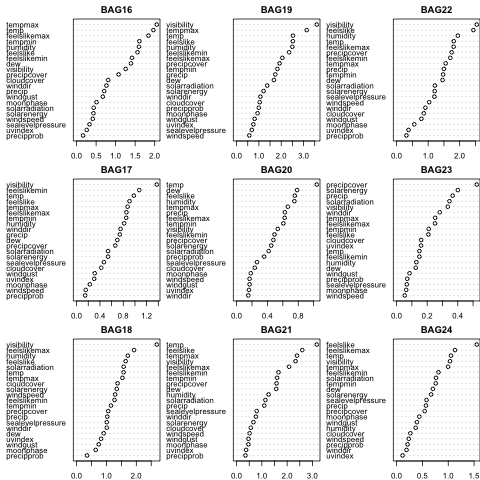

In [51]:
%%R
m1<-matrix(c(
    1,2,3,
    4,5,6,
    7,8,9),nrow=3)
layout(m1)
par(mar = c(2,0,2,0))
varImpPlot(BAG16)
varImpPlot(BAG17)
varImpPlot(BAG18)
varImpPlot(BAG19)
varImpPlot(BAG20)
varImpPlot(BAG21)
varImpPlot(BAG22)
varImpPlot(BAG23)
varImpPlot(BAG24)

#### Predicting the following year with the model from the previous year and displaying error rates:

In [52]:
%%R

Yhat17 <- predict(BAG16, newdata = data_pca_subset[NY2017,])
Yhat18 <- predict(BAG17, newdata = data_pca_subset[NY2018,])
Yhat19 <- predict(BAG18, newdata = data_pca_subset[NY2019,])
Yhat20 <- predict(BAG19, newdata = data_pca_subset[NY2020,])
Yhat21 <- predict(BAG20, newdata = data_pca_subset[NY2021,])
Yhat22 <- predict(BAG21, newdata = data_pca_subset[NY2022,])
Yhat23 <- predict(BAG22, newdata = data_pca_subset[NY2023,])
Yhat24 <- predict(BAG23, newdata = data_pca_subset[NY2024,])

print(paste0("2016 predicting 2017:   ",mean(Yhat17 != data_pca_subset[NY2017,]$AnySnow)))
print(paste0("2017 predicting 2018:   ",mean(Yhat18 != data_pca_subset[NY2018,]$AnySnow)))
print(paste0("2018 predicting 2019:   ",mean(Yhat19 != data_pca_subset[NY2019,]$AnySnow)))
print(paste0("2019 predicting 2020:   ",mean(Yhat20 != data_pca_subset[NY2020,]$AnySnow)))
print(paste0("2020 predicting 2021:   ",mean(Yhat21 != data_pca_subset[NY2021,]$AnySnow)))
print(paste0("2021 predicting 2022:   ",mean(Yhat22 != data_pca_subset[NY2022,]$AnySnow)))
print(paste0("2022 predicting 2023:   ",mean(Yhat23 != data_pca_subset[NY2023,]$AnySnow)))
print(paste0("2023 predicting 2024:   ",mean(Yhat24 != data_pca_subset[NY2024,]$AnySnow)))

[1] "2016 predicting 2017:   0.0136986301369863"
[1] "2017 predicting 2018:   0.0191780821917808"
[1] "2018 predicting 2019:   0.0273972602739726"
[1] "2019 predicting 2020:   0.0109289617486339"
[1] "2020 predicting 2021:   0.0273972602739726"
[1] "2021 predicting 2022:   0.0356164383561644"
[1] "2022 predicting 2023:   0.00821917808219178"
[1] "2023 predicting 2024:   0.0163934426229508"


#### We can see that there are some differences from year to year in the most important variables in the random forest. However, each model has quite low errors rates in classifying days with snow the following year.

#### Because random forest does not account for multicollinearity, some models have two highly correlated variables as the most important (e.g. in 2016, temp and tempmax have correlation of 0.982526 (cell # 10 above). 

#### Let's return to clustering and try to better visualize the data using the features we found to be most important when using all data points (visilibity and feelslike, whose correlation is relatively low (0.144217)).

#### Revisit K-means, plotting using principle components vs the data itself:

In [53]:
kmeans_pca_FullData=pd.concat([kmeans_pca_data,data_pca.loc[:,data_pca.columns!='AnySnow']],axis=1)
kmeans_pca_FullData

,AnySnow,pc1,pc2,pc3,pc4,pc5,pc6,cluster,tempmax,tempmin,...,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase
0,0,-4.060692,-1.753293,0.188650,0.647205,-0.003169,0.238094,1,33.1,22.8,...,34.9,15.9,260.4,1011.7,48.5,16.0,265.1,22.9,8,0.54
1,0,-3.681087,-1.792804,0.016489,0.591408,-0.066992,0.345403,1,32.0,22.8,...,22.0,22.3,248.3,1013.6,61.2,16.0,259.1,22.4,8,0.58
2,0,-4.163714,-1.731195,0.732674,0.704369,-0.441315,0.399463,1,33.2,21.8,...,38.5,24.8,186.0,1011.1,45.8,16.0,277.0,24.1,9,0.61
3,0,-4.315657,-0.240510,1.430443,0.749338,-0.615676,0.590692,1,35.3,24.9,...,47.9,22.6,232.8,1012.3,65.7,14.7,254.7,21.9,9,0.65
4,0,-4.155223,-1.838720,0.734430,0.621304,-0.060551,0.746573,1,33.6,24.0,...,36.7,21.6,315.9,1014.1,59.6,16.0,273.5,23.7,9,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,0,-3.748280,-1.106450,-1.410203,0.610940,-0.468408,0.975526,1,33.3,22.5,...,18.4,17.0,139.4,1018.8,40.4,15.1,207.7,18.1,8,0.78
3315,0,-4.241470,-0.609057,0.090421,-0.024224,0.538112,1.204108,1,37.8,24.2,...,38.9,23.1,219.7,1016.2,70.3,16.0,194.8,16.9,7,0.81
3316,0,-3.536522,1.942370,-0.481046,0.328005,-1.219985,1.115817,1,32.8,23.3,...,27.7,23.3,60.9,1019.4,73.8,14.9,133.6,11.5,8,0.85
3317,0,-1.248946,3.895639,-2.212529,-0.359038,-0.178814,1.350902,1,23.8,22.2,...,18.4,19.8,60.9,1022.0,99.2,12.8,39.6,3.4,2,0.88


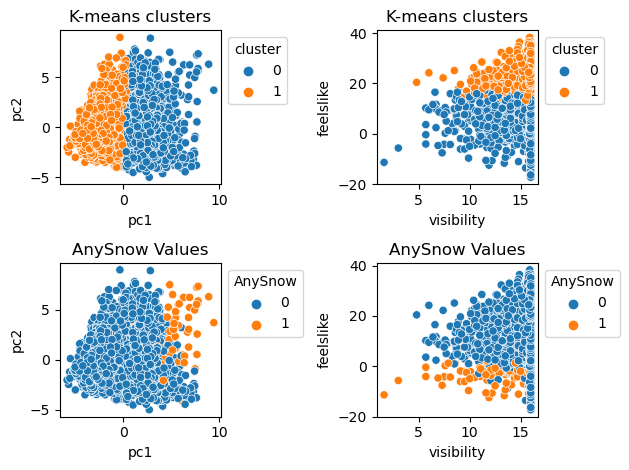

In [54]:
plt.subplot(2,2,1)
sns.scatterplot(x=kmeans_pca_FullData.pc1, y=kmeans_pca_FullData.pc2, hue=kmeans_pca_FullData.cluster)
plt.title('K-means clusters')
plt.legend(bbox_to_anchor=[1, 1], title="cluster")

plt.subplot(2,2,2)
sns.scatterplot(x=kmeans_pca_FullData.visibility, y=kmeans_pca_FullData.feelslike, hue=kmeans_pca_FullData.cluster)
plt.title('K-means clusters')
plt.legend(bbox_to_anchor=[1, 1], title="cluster")

plt.subplot(2,2,3)
sns.scatterplot(x=kmeans_pca_FullData.pc1, y=kmeans_pca_FullData.pc2, hue=kmeans_pca_FullData.AnySnow)
plt.title('AnySnow Values')
plt.legend(bbox_to_anchor=[1, 1], title="AnySnow")

plt.subplot(2,2,4)
sns.scatterplot(x=kmeans_pca_FullData.visibility, y=kmeans_pca_FullData.feelslike, hue=kmeans_pca_FullData.AnySnow)
plt.title('AnySnow Values')
plt.legend(bbox_to_anchor=[1, 1], title="AnySnow")

plt.tight_layout()

### By observing the clusters versus the actual AnySnow values, it does not appear that using the principal components aids much in separating clusters based on AnySnow. 

# Conclusion:
### Of the methods used here, the random forest built using all data points from 2015-2024 seems to be the best model to classify days with and without snow fall.

### It is possible that a non-linear clustering algorithm might be effective, but the random forest had a very low OOB error, so it seems to do a good job at classifying this large data set.

# Next:
### Future analyses will use regression methods to see if we can project what snowfall might look like for the upcoming winter of 2024-2025. 
### Analyses will also look at how features identified here (i.e."feelslike" and "visibility") have changed over the years, and how that might impact the random forest classifier that we have just identified.